## Cats vs. Dogs ##
In this project our objective will be distinguishing between images of cats and images of dogs.

Kaggle link: https://www.kaggle.com/competitions/dogs-vs-cats/overview

### Preparing the Data ###

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import os, cv2
import numpy as np

# dog = 0, cat = 1
def LoadAnimals(directory, clustering=0):
    x = []
    y = []

    for filename in os.listdir(directory):
        if 'dog' in filename:
            animal_class = 0
        else: # cat
            animal_class = 1

        f = os.path.join(directory, filename)
        image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)

        if clustering != 0:
            reshaped_image = image.reshape(-1, 3)
            kmeans = KMeans(n_clusters=clustering).fit(reshaped_image)
            segmented_img = kmeans.cluster_centers_[kmeans.labels_]
            segmented_img = segmented_img.reshape(image.shape)
            image = segmented_img

        x.append(np.concatenate(image)) # sklearn doesn't like 3d arrays (x_train is an array of 2d arrays -> 3d array). Transforms 3d array to 2d.
        y.append(animal_class)

    return x, y

In [2]:
x, y = LoadAnimals(r"C:\Users\Daniel\Pictures\resize100,100", clustering=0)

### PCA Preparation ###

In [3]:
import pandas as pd

In [4]:
df = pd.DataFrame(np.array(x))
df

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,168,173,177,180,185,188,190,193,197,198,...,3,3,3,2,2,2,2,2,2,2
1,43,43,44,43,52,32,52,37,40,61,...,47,50,48,50,55,61,63,89,18,35
2,39,25,42,52,45,55,61,55,54,58,...,157,157,149,134,129,149,159,168,171,153
3,220,224,223,227,229,223,226,235,229,226,...,229,213,206,204,202,214,222,215,212,213
4,117,117,122,92,78,97,134,130,150,180,...,95,95,95,91,101,121,96,90,93,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,140,142,143,145,146,147,148,149,148,149,...,164,165,166,166,167,168,168,168,168,169
24996,119,77,103,84,99,114,71,82,85,87,...,95,94,80,98,86,77,85,94,92,76
24997,42,35,47,56,66,48,48,57,59,39,...,102,135,135,123,71,116,180,127,114,167
24998,253,250,246,234,223,208,187,145,114,73,...,120,101,106,112,112,112,106,118,115,119


In [5]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

'''pca_10000 = PCA(n_components=10000)
pca_10000.fit(df)

plt.grid()
plt.plot(np.cumsum(pca_10000.explained_variance_ratio_ * 1000))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.savefig('Scree plot.png') '''


"pca_10000 = PCA(n_components=10000)\npca_10000.fit(df)\n\nplt.grid()\nplt.plot(np.cumsum(pca_10000.explained_variance_ratio_ * 1000))\nplt.xlabel('Number of components')\nplt.ylabel('Explained variance')\nplt.savefig('Scree plot.png') "

Lets test n_components = 1000

In [6]:
pca_1000 = PCA(n_components=1000)
pca_1000.fit(df)

PCA(n_components=1000)

In [7]:
np.cumsum(pca_1000.explained_variance_ratio_ * 100)[-1]

94.30859765889123

In [8]:
transformed_x = pca_1000.fit_transform(x)

## Analyzing Feature Importance ##
Using Random Forest.

In [9]:
def array1dto2d(arr, w, h):
    if w*h != len(arr):
        return None
    else:
        ret = []
        for i in range(0, h):
            ret.append( arr[w*i:w*(i+1)] )
        return ret

In [10]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from matplotlib.colors import ListedColormap

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(x, y)

impprtances = array1dto2d(rnd_clf.feature_importances_, 100, 100)

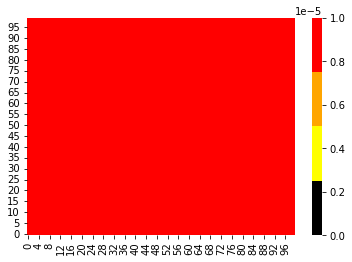

In [11]:
sns.heatmap(impprtances, vmin=0, vmax=0.001, cmap=ListedColormap(['black', 'yellow', 'orange', 'red']))
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.show()

Conclusion: It seems our pictures don't have a pattern and a specific area in which the important (or non-important, a dead space such the top right corner commonly being a wall) information is.

# Models #

In [17]:
from sklearn.model_selection import cross_val_score

def Test(name, model, new_x=transformed_x, new_y=y):
    score = abs(np.median( cross_val_score(model, new_x, new_y, cv=10, scoring='accuracy') ))
    print('{}: {}'.format(name, score))

First we will run a dummy to set our baseline.

In [18]:
from sklearn.dummy import DummyClassifier
Test('Dummy (stratified)', DummyClassifier(strategy="stratified"))
Test('Dummy (most_frequent)', DummyClassifier(strategy="most_frequent"))

Dummy (stratified): 0.49860000000000004
Dummy (most_frequent): 0.5


Next we will try out Logistic Regression (without high hopes).

In [20]:
from sklearn.linear_model import LogisticRegression
Test('Logistic Regression', LogisticRegression())

C:\Users\Daniel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Daniel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Logistic Regression: 0.5438000000000001


C:\Users\Daniel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
from sklearn.ensemble import RandomForestClassifier
Test('Random Forest', RandomForestClassifier())

Random Forest: 0.5898


Lets try some new models: AdaBoost, XGBoost.

In [22]:
from xgboost import XGBClassifier
Test('XGBoost', XGBClassifier())

C:\Users\Daniel\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:01:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
Test('AdaBoost', AdaBoostClassifier())

AdaBoost: 0.535


In [23]:
from sklearn.neighbors import KNeighborsClassifier
Test('KNN', KNeighborsClassifier())

KNN: 0.5744


In [ ]:
from sklearn.svm import SVC
Test('SVC', SVC())

In [ ]:
from sklearn.naive_bayes import GaussianNB
Test('GaussianNB', GaussianNB())

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
Test('GradientBoosting', GradientBoostingClassifier() )

In [27]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

estimators = []
model1 = LogisticRegression(); estimators.append(("logistic", model1))
model2 = RandomForestClassifier(); estimators.append(("RandomForest", model2))
model3 = SVC(); estimators.append(("svc", model3))
model4 = XGBClassifier(); estimators.append(("XGB",model4))
model5 = AdaBoostClassifier(); estimators.append(("AdaB",model5))
model6 = KNeighborsClassifier(); estimators.append(("KNN",model6))
model7 = GaussianNB(); estimators.append(("GuassianNB",model7))
model8 = GradientBoostingClassifier(); estimators.append(("GradientBoosting",model8))

ensemble = VotingClassifier(estimators)

Test("HardVoting",ensemble)

C:\Users\Daniel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KeyboardInterrupt: 

Now lets run our models together using Bagging.

In [ ]:
#from sklearn.ensemble import BaggingClassifier
#bagging = BaggingClassifier(RandomForestClassifier(), n_estimators=10, max_samples=2000)
#Test('Bagging Classifier', bagging)